In [1]:
from main import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
%%time 
#Fitting for Model 1: (without CD) #using curve_fit
fit = Fitting('KMC_NonDynamic_Data_iCovg_iRates.csv','Atomic.csv','Stoich.csv','Param.csv',Input_Type='iCovg_iRates') #covgdep = Allowing for coverage dependance to be considered in the fit
fit.set_rxnconditions() #Sets the Pressures and Temperature as defined from the Param file. (Note: One can also enter them manually - See main.py for syntax)
fit.set_limits_of_integration(fit.Input.iloc[0,0],fit.Input.iloc[-1,0])
fit.n_extract = 0.5

Mass is conserved. 

CPU times: user 22.7 ms, sys: 2.03 ms, total: 24.7 ms
Wall time: 24.4 ms


<IPython.core.display.Javascript object>


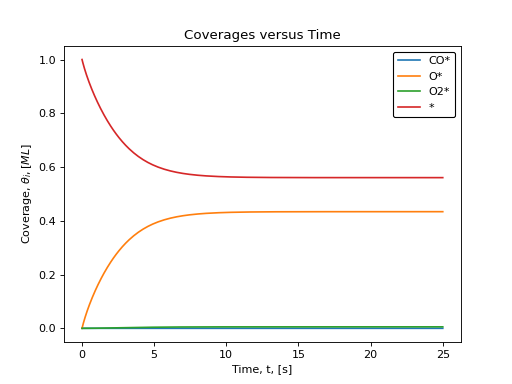

In [3]:
kfit1 = np.array([7.24446662e+06, 1.48359014e+04, 9.21074095e+06, 6.35719296e+00,
 1.26711213e+06, 2.06799121e+04, 2.25184309e+05, 4.08984436e+06])
fit.MKM.k = kfit1
sola1,solta1= fit.MKM.solve_coverage(plot=True) #Obtains the coverages(sol) with respect to time(solt) and plots them if plot=True (Note: Additional options can be set manually - See main.py for syntax)

<IPython.core.display.Javascript object>


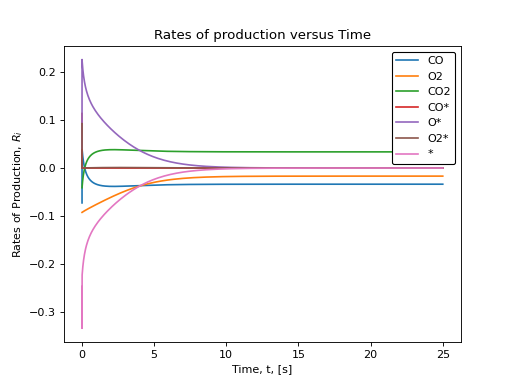

In [4]:
solb1,soltb1 = fit.MKM.solve_rate_production(plot=True)

### Comparing steady state rates of prod.

In [5]:
#From Input:
Inp = fit.Input.iloc[-1,-3:].to_numpy() # CO | O2 | CO2
print(Inp)

[-0.02115885 -0.02441406  0.02875434]


In [6]:
#From Simulation (With fitted rate constants)
RateVec = fit.MKM.get_SS_rates_production()[:len(fit.MKM.Pextract())]
print(RateVec)

[-0.03356377 -0.01678209  0.03356377]


In [7]:
#Calculating %difference
pd = np.empty(len(RateVec))
for i in np.arange(len(RateVec)):
    pd[i] = np.abs((Inp[i]-RateVec[i])/(Inp[i]))*100
    
print(pd)

[58.6275303  31.2605584  16.72591851]


### Degree of rate control

In [8]:
fit.MKM.get_X_RC_SS(k_o_inp=kfit1)

[0.9258109491355562,
 -5.033837642540448,
 -4.99988580018114,
 0.13069748585434357]